<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://towardsai.net/p/machine-learning/patchtst-a-step-forward-in-time-series-forecasting

# https://towardsdatascience.com/patchtst-a-breakthrough-in-time-series-forecasting-e02d48869ccc

# https://github.com/thehaseebhassan/medium/blob/main/PatchTST/PatchTST.ipynb


# Initial Setup

If you have CUDA installed, then neuralforecast will automatically leverage your GPU to train the models. On my end, I do not have it installed, which is why I am not doing extensive hyperparameter tuning, or training on very large datasets.

Once that is done, let’s download the Exchange dataset.

Y_df, X_df, S_df = LongHorizon.load(directory="./data", group="Exchange")

Here, we see that we get three DataFrames. The first one contains the daily exchange rates for each country.

The second one contains exogenous time series. The third one, contains static exogenous variables (like day, month, year, hour, or any future information that we know).

For this exercise, we only work with Y_df.

Then, let’s make sure that the dates have the right type.

In [2]:
### Initial setup ###

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install neuralforecast datasetsforecast

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 19.2 MB/s 

# CUDA Settings



In [3]:
torch.cuda.is_available()

True

In [4]:
Y_df, X_df, S_df = LongHorizon.load(directory="./data", group="Exchange")

100%|██████████| 314M/314M [00:12<00:00, 24.5MiB/s]


In [5]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df.head()

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966


In [6]:
Y_df['unique_id'].value_counts()

0     7588
1     7588
2     7588
3     7588
4     7588
5     7588
6     7588
OT    7588
Name: unique_id, dtype: int64

In [7]:
n_time = len(Y_df.ds.unique())
val_size = 760
test_size = 1517

print(n_time, val_size, test_size)

Y_df.groupby('unique_id').head(2)

7588 760 1517


,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
7588,1,1990-01-01,-0.361671
7589,1,1990-01-02,-0.367639
15176,2,1990-01-01,0.735367
15177,2,1990-01-02,0.729629
22764,3,1990-01-01,-1.164373
22765,3,1990-01-02,-1.170907
30352,4,1990-01-01,2.851890
30353,4,1990-01-02,2.851890


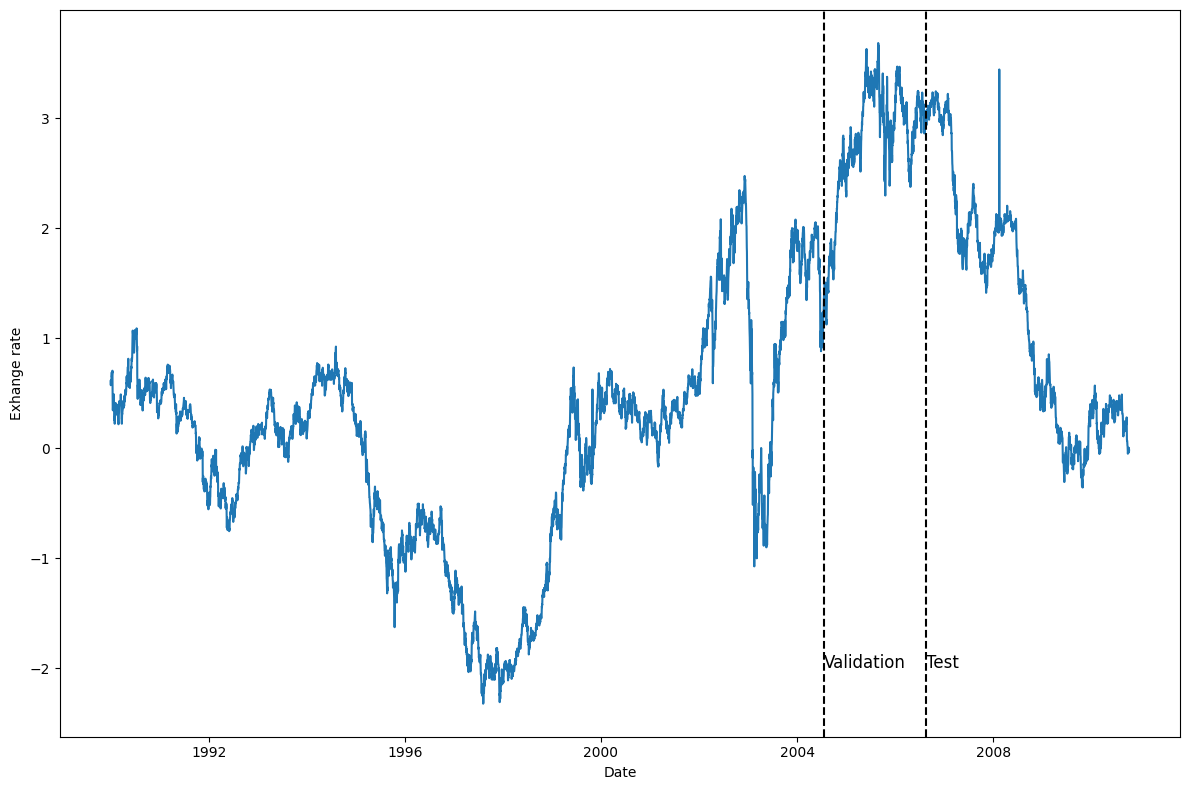

In [8]:
u_id = '0'

x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_plot

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, 'Validation', fontsize=12)
plt.text(x_test,-2, 'Test', fontsize=12)

plt.tight_layout()

# Modelling

Having explored the data, let’s get started on modelling with neuralforecast.

First, we need to set the horizon. In this case, I use 96 time steps, as this horizon is also used in the PatchTST paper.

Then, to have a fair evaluation of each model, I decided to set the input size to twice the horizon (so 192 time steps), and set the maximum number of epochs to 50. All other hyperparameters are kept to their default values.

In [9]:
### Modelling ###

horizon = 96

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [10]:
nf = NeuralForecast(models=models, freq='D')

Forecasting

To generate predictions, we use the cross_validation method to make use of the validation and test sets. It will return a DataFrame with predictions from all models and the associated true value.

In [11]:
### Forecasting ###

preds_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [12]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y
0,0,2006-08-16,2006-08-15,2.926860,2.922099,2.909714,2.948076
1,0,2006-08-17,2006-08-15,2.915872,2.892621,2.925045,3.049320
2,0,2006-08-18,2006-08-15,2.931864,2.923665,2.930937,3.064168
3,0,2006-08-19,2006-08-15,2.910580,2.885182,2.951308,3.005783
4,0,2006-08-20,2006-08-15,2.898122,2.929641,2.944182,3.010031


In [13]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values

n_series = len(Y_df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

print(y_true.shape)
print(y_pred_nhits.shape)

(8, 1422, 96)
(8, 1422, 96)


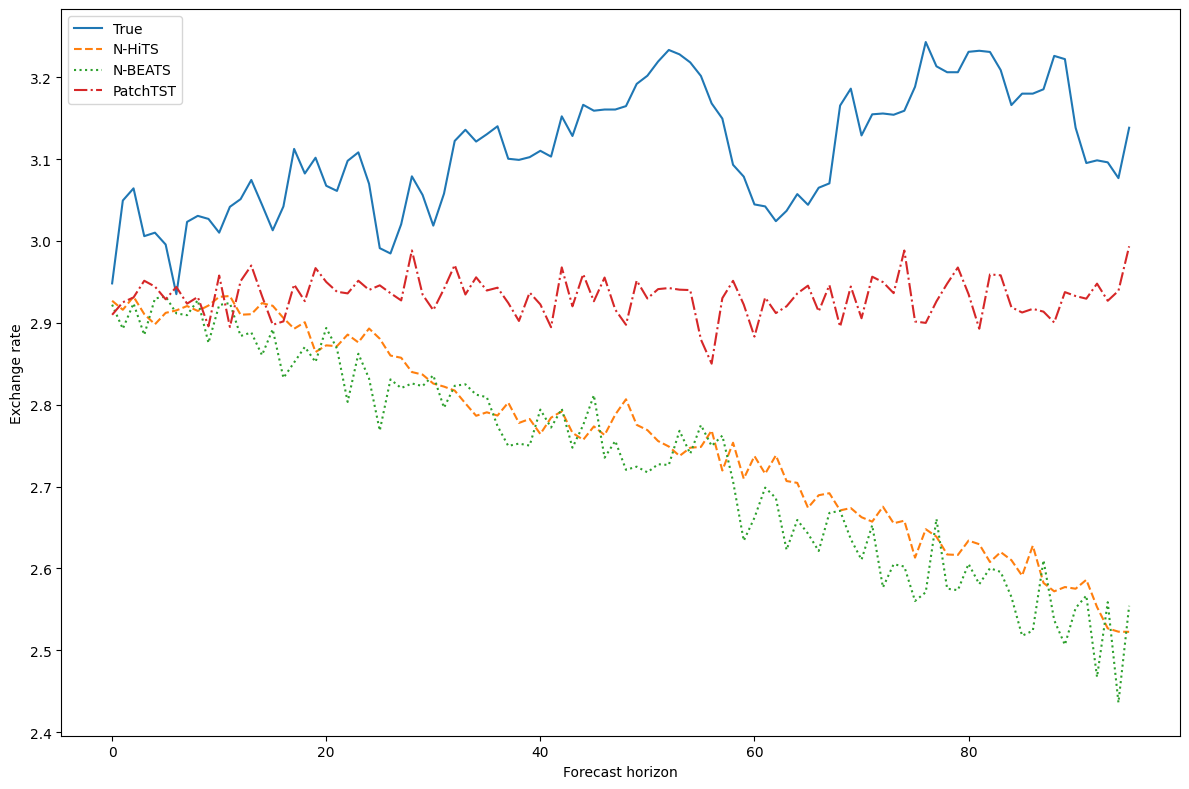

In [14]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')

plt.tight_layout()

# Evaluation


# New Section

Evaluation So, let’s evaluate the performance of each model. To replicate the methodology from the paper, we use both the MAE and MSE as performance metrics

In [15]:
### Evaluation ###

data = {'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='blue', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.202874,0.204591,0.197683
mse,0.081844,0.082580,0.081251
